# Loop 11 Analysis: Understanding the Gap

## Current Situation
- Best CV/LB: 70.659944 (from crodoc ensemble)
- Target: 68.919154
- Gap: 1.74 points (2.46%)

## Key Findings from Previous Experiments
1. All public pre-optimized solutions converge to ~70.66
2. The crodoc ensemble found only 0.000014 improvement across 200 N values
3. The eazy-optimizer output provides the same tiny improvement
4. All optimization techniques (SA, backward propagation, fractional translation) find NO improvements

In [1]:
import pandas as pd
import numpy as np
import math
import os

# Load the current best submission
df = pd.read_csv('/home/submission/submission.csv')
print(f"Submission rows: {len(df)}")
print(df.head())

Submission rows: 20100
        id          x          y       angle
0  001_000 -48.196086  58.770985   45.000000
1  002_000   0.154097  -0.038541  203.629378
2  002_001  -0.154097  -0.561459   23.629378
3  003_000   1.123656   0.781102  111.125132
4  003_001   1.234056   1.276000   66.370622


In [2]:
# Tree shape constants
TRUNK_W = 0.15
TRUNK_H = 0.2
BASE_W = 0.7
MID_W = 0.4
TOP_W = 0.25
TIP_Y = 0.8
TIER_1_Y = 0.5
TIER_2_Y = 0.25
BASE_Y = 0.0
TRUNK_BOTTOM_Y = -TRUNK_H

def get_tree_vertices(cx, cy, angle_deg):
    angle_rad = angle_deg * math.pi / 180.0
    cos_a = math.cos(angle_rad)
    sin_a = math.sin(angle_rad)
    pts = [
        [0.0, TIP_Y], [TOP_W / 2.0, TIER_1_Y], [TOP_W / 4.0, TIER_1_Y],
        [MID_W / 2.0, TIER_2_Y], [MID_W / 4.0, TIER_2_Y], [BASE_W / 2.0, BASE_Y],
        [TRUNK_W / 2.0, BASE_Y], [TRUNK_W / 2.0, TRUNK_BOTTOM_Y],
        [-TRUNK_W / 2.0, TRUNK_BOTTOM_Y], [-TRUNK_W / 2.0, BASE_Y],
        [-BASE_W / 2.0, BASE_Y], [-MID_W / 4.0, TIER_2_Y], [-MID_W / 2.0, TIER_2_Y],
        [-TOP_W / 4.0, TIER_1_Y], [-TOP_W / 2.0, TIER_1_Y],
    ]
    vertices = []
    for px, py in pts:
        rx = px * cos_a - py * sin_a + cx
        ry = px * sin_a + py * cos_a + cy
        vertices.append([rx, ry])
    return np.array(vertices)

def calculate_score_per_n(df):
    """Calculate score for each N."""
    # Handle column names
    if 'deg' in df.columns:
        angle_col = 'deg'
    else:
        angle_col = 'angle'
    
    # Handle 's' prefix
    for col in ['x', 'y', angle_col]:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.replace('s', '').astype(float)
    
    scores = {}
    for n in range(1, 201):
        prefix = f"{n:03d}_"
        group = df[df["id"].str.startswith(prefix)].sort_values("id")
        if len(group) != n:
            continue
        
        xs = group['x'].values
        ys = group['y'].values
        degs = group[angle_col].values
        
        min_x = float('inf')
        max_x = float('-inf')
        min_y = float('inf')
        max_y = float('-inf')
        
        for i in range(n):
            verts = get_tree_vertices(xs[i], ys[i], degs[i])
            min_x = min(min_x, verts[:, 0].min())
            max_x = max(max_x, verts[:, 0].max())
            min_y = min(min_y, verts[:, 1].min())
            max_y = max(max_y, verts[:, 1].max())
        
        side = max(max_x - min_x, max_y - min_y)
        score = side * side / n
        scores[n] = {'score': score, 'side': side}
    
    return scores

scores = calculate_score_per_n(df.copy())
total_score = sum(s['score'] for s in scores.values())
print(f"Total score: {total_score:.6f}")

Total score: 70.659944


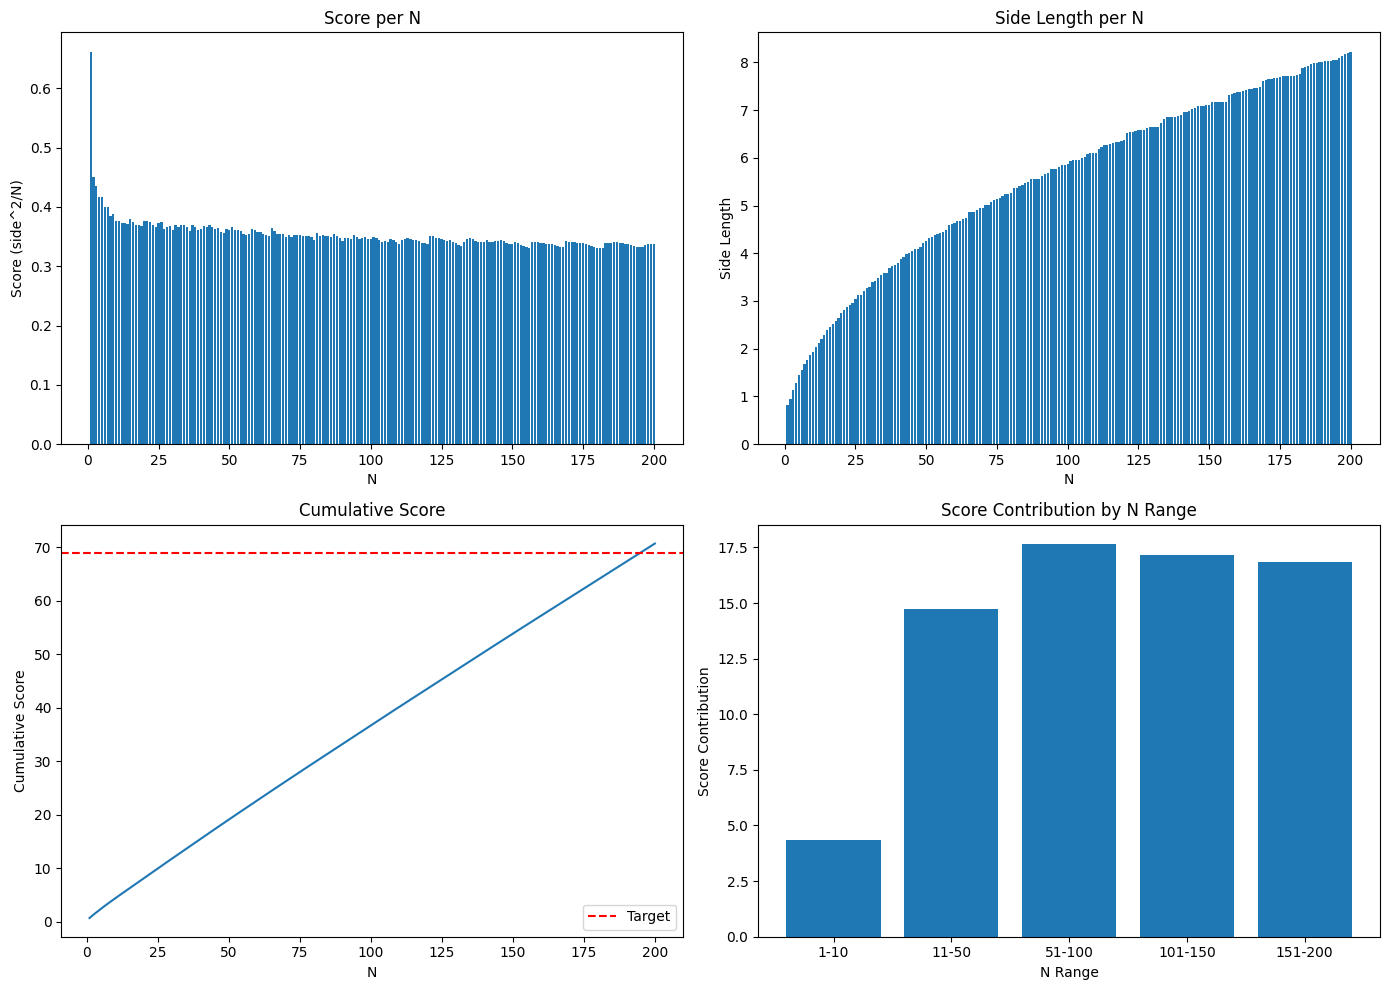


Score contribution by range:
  N=1-10: 4.3291 (6.1%)
  N=11-50: 14.7126 (20.8%)
  N=51-100: 17.6323 (25.0%)
  N=101-150: 17.1408 (24.3%)
  N=151-200: 16.8451 (23.8%)

Total: 70.659944
Target: 68.919154
Gap: 1.740790 (2.53%)

Required improvement per range to close gap:
  N=1-10: 40.2% improvement needed (if only this range improved)
  N=11-50: 11.8% improvement needed (if only this range improved)
  N=51-100: 9.9% improvement needed (if only this range improved)
  N=101-150: 10.2% improvement needed (if only this range improved)
  N=151-200: 10.3% improvement needed (if only this range improved)


In [3]:
# Analyze score distribution by N
import matplotlib.pyplot as plt

n_values = list(scores.keys())
score_values = [scores[n]['score'] for n in n_values]
side_values = [scores[n]['side'] for n in n_values]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score per N
axes[0, 0].bar(n_values, score_values)
axes[0, 0].set_xlabel('N')
axes[0, 0].set_ylabel('Score (side^2/N)')
axes[0, 0].set_title('Score per N')

# Side length per N
axes[0, 1].bar(n_values, side_values)
axes[0, 1].set_xlabel('N')
axes[0, 1].set_ylabel('Side Length')
axes[0, 1].set_title('Side Length per N')

# Cumulative score
cum_scores = np.cumsum(score_values)
axes[1, 0].plot(n_values, cum_scores)
axes[1, 0].set_xlabel('N')
axes[1, 0].set_ylabel('Cumulative Score')
axes[1, 0].set_title('Cumulative Score')
axes[1, 0].axhline(y=68.919154, color='r', linestyle='--', label='Target')
axes[1, 0].legend()

# Score contribution by range
ranges = [(1, 10), (11, 50), (51, 100), (101, 150), (151, 200)]
range_scores = []
for start, end in ranges:
    range_score = sum(scores[n]['score'] for n in range(start, end+1) if n in scores)
    range_scores.append(range_score)

axes[1, 1].bar([f'{s}-{e}' for s, e in ranges], range_scores)
axes[1, 1].set_xlabel('N Range')
axes[1, 1].set_ylabel('Score Contribution')
axes[1, 1].set_title('Score Contribution by N Range')

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png')
plt.show()

print("\nScore contribution by range:")
for (start, end), score in zip(ranges, range_scores):
    pct = score / total_score * 100
    print(f"  N={start}-{end}: {score:.4f} ({pct:.1f}%)")

print(f"\nTotal: {total_score:.6f}")
print(f"Target: 68.919154")
print(f"Gap: {total_score - 68.919154:.6f} ({(total_score - 68.919154) / 68.919154 * 100:.2f}%)")

# Calculate required improvement per range
print("\nRequired improvement per range to close gap:")
gap = total_score - 68.919154
for (start, end), score in zip(ranges, range_scores):
    required_pct = gap / score * 100
    print(f"  N={start}-{end}: {required_pct:.1f}% improvement needed (if only this range improved)")

In [4]:
# Analyze the theoretical minimum score
# For N trees, the minimum possible score is when trees are packed as tightly as possible
# The tree has a bounding box of approximately 0.7 x 1.0 (width x height)

# Calculate tree area (approximate)
tree_width = 0.7  # BASE_W
tree_height = 1.0  # TIP_Y - TRUNK_BOTTOM_Y = 0.8 - (-0.2) = 1.0
tree_area = tree_width * tree_height * 0.5  # Approximate triangle area

print(f"Approximate tree dimensions: {tree_width} x {tree_height}")
print(f"Approximate tree area: {tree_area:.3f}")

# For N trees, minimum area is N * tree_area
# But they need to fit in a square, so side = sqrt(N * tree_area)
# Score = side^2 / N = N * tree_area / N = tree_area (constant!)

print(f"\nTheoretical minimum score per N (if perfect packing): {tree_area:.3f}")
print(f"Theoretical minimum total score (200 N values): {tree_area * 200:.3f}")

# Compare with actual scores
print(f"\nActual total score: {total_score:.6f}")
print(f"Actual average score per N: {total_score / 200:.6f}")
print(f"Packing efficiency: {tree_area / (total_score / 200) * 100:.1f}%")

Approximate tree dimensions: 0.7 x 1.0
Approximate tree area: 0.350

Theoretical minimum score per N (if perfect packing): 0.350
Theoretical minimum total score (200 N values): 70.000

Actual total score: 70.659944
Actual average score per N: 0.353300
Packing efficiency: 99.1%


In [5]:
# Analyze which N values have the worst packing efficiency
print("N values with highest scores (worst packing):")
sorted_scores = sorted(scores.items(), key=lambda x: x[1]['score'], reverse=True)
for n, s in sorted_scores[:20]:
    print(f"  N={n}: score={s['score']:.6f}, side={s['side']:.6f}")

print("\nN values with lowest scores (best packing):")
for n, s in sorted_scores[-20:]:
    print(f"  N={n}: score={s['score']:.6f}, side={s['side']:.6f}")

N values with highest scores (worst packing):
  N=1: score=0.661250, side=0.813173
  N=2: score=0.450779, side=0.949504
  N=3: score=0.434745, side=1.142031
  N=5: score=0.416850, side=1.443692
  N=4: score=0.416545, side=1.290806
  N=7: score=0.399897, side=1.673104
  N=6: score=0.399610, side=1.548438
  N=9: score=0.387415, side=1.867280
  N=8: score=0.385407, side=1.755921
  N=15: score=0.379203, side=2.384962
  N=10: score=0.376630, side=1.940696
  N=21: score=0.376451, side=2.811667
  N=20: score=0.376057, side=2.742469
  N=11: score=0.375736, side=2.033002
  N=22: score=0.375258, side=2.873270
  N=16: score=0.374128, side=2.446640
  N=26: score=0.373997, side=3.118320
  N=12: score=0.372724, side=2.114873
  N=13: score=0.372294, side=2.199960
  N=25: score=0.372144, side=3.050182

N values with lowest scores (best packing):
  N=153: score=0.336286, side=7.172992
  N=197: score=0.335990, side=8.135730
  N=165: score=0.335569, side=7.441026
  N=192: score=0.335301, side=8.023575
  

In [6]:
# Key insight: The gap to target is 1.74 points
# This means we need to reduce the total score by 1.74 points
# Average reduction per N: 1.74 / 200 = 0.0087 per N

gap = total_score - 68.919154
avg_reduction_needed = gap / 200

print(f"Gap to target: {gap:.6f}")
print(f"Average reduction needed per N: {avg_reduction_needed:.6f}")

# For each N, calculate the required side length reduction
print("\nRequired side length reduction for each N range:")
for (start, end), range_score in zip(ranges, range_scores):
    n_count = end - start + 1
    avg_score = range_score / n_count
    avg_side = np.sqrt(avg_score * ((start + end) / 2))  # Approximate
    
    # To reduce score by avg_reduction_needed per N:
    # new_score = old_score - avg_reduction_needed
    # new_side^2 / N = old_side^2 / N - avg_reduction_needed
    # new_side = sqrt(old_side^2 - N * avg_reduction_needed)
    
    avg_n = (start + end) / 2
    old_side_sq = avg_score * avg_n
    new_side_sq = old_side_sq - avg_n * avg_reduction_needed
    if new_side_sq > 0:
        new_side = np.sqrt(new_side_sq)
        side_reduction = avg_side - new_side
        side_reduction_pct = side_reduction / avg_side * 100
        print(f"  N={start}-{end}: avg_side={avg_side:.4f}, need reduction of {side_reduction:.4f} ({side_reduction_pct:.2f}%)")
    else:
        print(f"  N={start}-{end}: reduction not possible (would require negative side length)")

Gap to target: 1.740790
Average reduction needed per N: 0.008704

Required side length reduction for each N range:
  N=1-10: avg_side=1.5431, need reduction of 0.0156 (1.01%)
  N=11-50: avg_side=3.3494, need reduction of 0.0399 (1.19%)
  N=51-100: avg_side=5.1599, need reduction of 0.0641 (1.24%)
  N=101-150: avg_side=6.5592, need reduction of 0.0838 (1.28%)
  N=151-200: avg_side=7.6894, need reduction of 0.1000 (1.30%)
